In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import time

In [14]:
plt.style.use('seaborn') #plt.style.use('seaborn')

## Data extraction

In [15]:
import os

In [16]:
DATA_ROOT = './models-performance'
MODEL_NAME = 'adaptive-softmax-4-transformer-layers'

In [17]:
model_names = os.listdir(DATA_ROOT)

1T-4H.txt
2T-8H-A.txt


c:\python37\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2T.txt
4T-1H-A.txt
4T-1H.txt
4T-4H-A.txt
MLP.txt
SIOE.txt


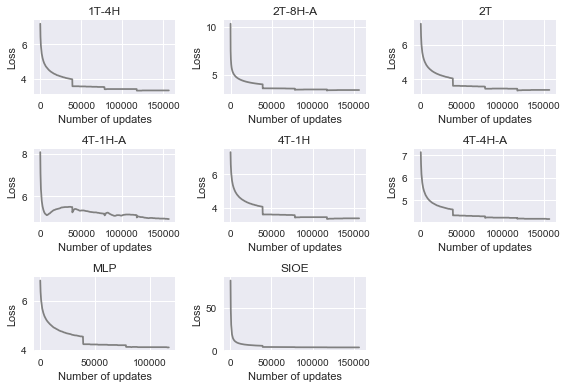

In [24]:
x, y = 3, 3
pos = 1,2,3,4,5,6,7,8


for i, model_name in zip(pos, model_names):
    print(model_name)
    model_performance_raw = open(f'{DATA_ROOT}/{model_name}').readlines()
    epoch_data = list()
    batch_data = list()

    last_is_epoch = False
    epoch = 0

    for line in model_performance_raw:
        line = line.replace('\n', '"}')

        if line.startswith('Train:'):
            if last_is_epoch:
                epoch += 1
                last_is_epoch = False
            line = line.replace('Train: ', '').replace('=',':').replace(', ','","').replace(':','":"')
            line = '{"epoch":"' + str(epoch) + '","' + line
            batch_data.append(json.loads(line))

        elif line.startswith('|'):
            last_is_epoch = True
            line = line.replace('| epoch ', '{"epoch=').replace(' |',',').replace('=','":"')
            line = line.replace(', ', '","').replace('train ', '').replace('valid ', '').replace('%','')
            line = line.replace(' (wikipedia)', '", "dataset":"wikipedia')
            line = line.replace(' (El PeriÃ³dico)', '", "dataset":"periodico')
            if not 'wiki' in line and not 'period' in line:
                continue
            if not line.endswith('"}'):
                line += '"}'
            #print(line)
            epoch_data.append(json.loads(line))

    
    batch_df = pd.DataFrame(batch_data, dtype=float)
    epoch_df = pd.DataFrame(epoch_data, dtype=float)
    #
    batch_df['dataset'] = 'training'
    batch_df['num_updates'] = batch_df.apply(lambda r: r['epoch']*39177 + r['num_updates'], axis=1)
    #
    epoch_df['num_updates'] = epoch_df['epoch'].apply(lambda e: (e+1)*39177).astype(float)
    
    df = pd.concat((batch_df, epoch_df))
    
    ## PLOT
    plt.subplot(x, y, i)
    
    """
    groups = df.groupby("dataset")
    for name, group in groups:
        if name == 'training':
            plt.plot(group.num_updates, group.accuracy, '-', label=name)
        else:
            plt.plot(group.num_updates, group.accuracy, '-o', label=name)
    plt.xlabel('Number of updates')
    plt.ylabel('Accuracy (%)')
    plt.title(model_name[:-4])

    """
    plt.plot(batch_df.num_updates, batch_df.loss, 'gray')
    plt.xlabel('Number of updates')
    plt.ylabel('Loss')
    plt.title(model_name[:-4])

plt.tight_layout()
plt.savefig(f'./plots/loss-all.png')


## Accuracy test bars

In [86]:
models_stats = pd.read_csv('models-general-stats.txt')
models_stats['execution_time'] = models_stats['execution_time'].apply(lambda t: t/3600)

In [55]:
models_stats.head()

,model,execution_time,public_score,n_params
0,BASE,NaN,0.33064,51000000.0
1,2T-1H,4.188833,0.33583,52000000.0
2,4T-1H,5.027889,0.34166,53000000.0
3,4T-1H-A,4.494028,0.32666,28000000.0
4,1T-4H,3.808064,0.33583,51000000.0


Text(0.5, 0, 'Model')

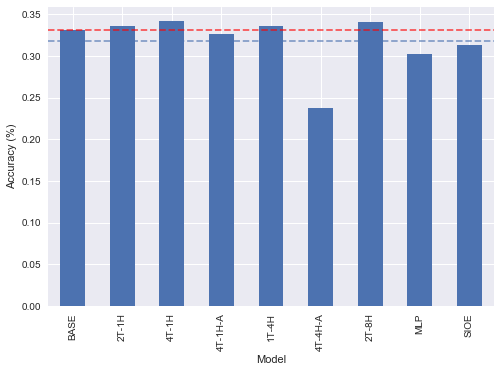

In [56]:
ax = models_stats.plot.bar(x='model', y='public_score', legend=False)
ax.axhline(models_stats.public_score.mean(), ls='--', alpha=.65)
ax.axhline(0.33064, ls='--', c='red', alpha=.65)
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model')

Text(0.5, 0, 'Model')

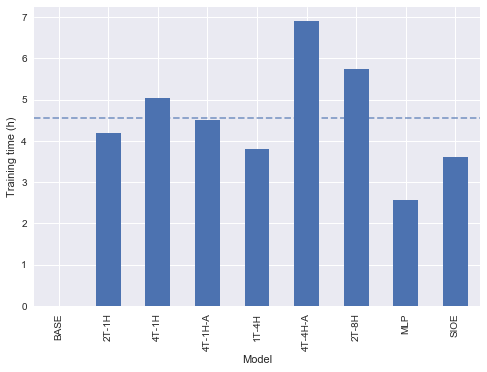

In [57]:
ax = models_stats.plot.bar(x='model', y='execution_time', legend=False)
ax.axhline(models_stats.execution_time.mean(), ls='--', alpha=.65)
ax.set_ylabel('Training time (h)')
ax.set_xlabel('Model')

Text(0.5, 0, 'Model')

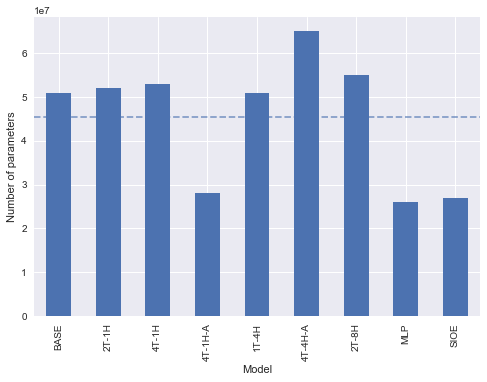

In [61]:
ax = models_stats.plot.bar(x='model', y='n_params', legend=False)
ax.axhline(models_stats.n_params.mean(), ls='--', alpha=.65)
ax.set_ylabel('Number of parameters')
ax.set_xlabel('Model')

0 model               2T-1H
execution_time    4.18883
public_score      0.33583
n_params          5.2e+07
Name: 0, dtype: object
1 model               4T-1H
execution_time    5.02789
public_score      0.34166
n_params          5.3e+07
Name: 1, dtype: object
2 model             4T-1H-A
execution_time    4.49403
public_score      0.32666
n_params          2.8e+07
Name: 2, dtype: object
3 model               1T-4H
execution_time    3.80806
public_score      0.33583
n_params          5.1e+07
Name: 3, dtype: object
4 model             4T-4H-A
execution_time    6.90022
public_score      0.23766
n_params          6.5e+07
Name: 4, dtype: object
5 model               2T-8H
execution_time    5.73969
public_score      0.34085
n_params          5.5e+07
Name: 5, dtype: object
6 model                 MLP
execution_time    2.57097
public_score      0.30264
n_params          2.6e+07
Name: 6, dtype: object
7 model                SIOE
execution_time    3.61567
public_score       0.3135
n_params         

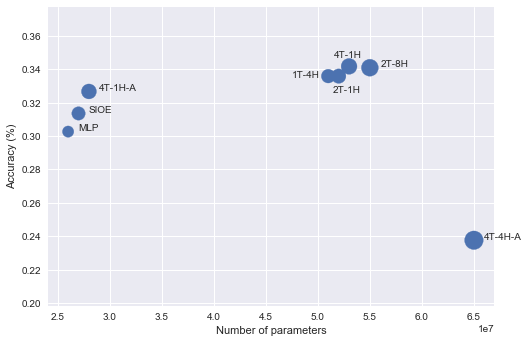

In [101]:
ax = models_stats.plot.scatter(x='n_params', y='public_score', s=models_stats['execution_time']*50)
ax.set_xlabel('Number of parameters')
ax.set_ylabel('Accuracy (%)')
for i, row in models_stats.iterrows():
    print(i, row)
    if row.model == '4T-1H':
        ax.annotate(row.model, (row.n_params-1.5e6, row.public_score+0.005))
    elif row.model == '2T-1H':
        ax.annotate(row.model, (row.n_params-.6e6, row.public_score-0.01))
    elif row.model == '1T-4H':
        ax.annotate(row.model, (row.n_params-3.5e6, row.public_score-0.001))
    else:
        ax.annotate(row.model, (row.n_params+1e6, row.public_score+0.0005))